# Task 5: Language Model [5p]

Build a basic language model using a publicly available text dataset. You'll experiment with RNN-based architectures (Simple RNN, LSTM, GRU) to learn how they model sequences.

### **Part 1: Dataset Download & Preparation (1 point)**

**Tasks:**

* Download a publicly available dataset, e.g., *Alice’s Adventures in Wonderland* from Project Gutenberg.
  * Use requests or a dataset API like torchtext.datasets.
* Preprocess the text:
  * Lowercase, remove non-alphabetic characters.
  * Tokenize into words (use nltk or spaCy).
  * Build a vocabulary, keeping frequent words (e.g., top 10k).
* Use **pretrained word embeddings** (e.g., GloVe 100d or FastText):
  * Load with torchtext.vocab, gensim, or similar.
  * Initialize the embedding layer with pretrained vectors.


### **Part 2: Build a Recurrent Language Model (1 point)**

**Tasks:**

* Implement a word-level language model using:
  * Pretrained embedding layer (frozen or trainable).
  * A single-layer **Simple RNN**.
  * A fully connected output layer with softmax.

### **Part 3: Train the Model (1 point)**

**Tasks:**

* Use cross-entropy loss.
* Predict the next word from a sequence.
* Use teacher forcing and batching.
* Plot training loss over time.

### **Part 4: Generate Text (1 point)**

**Tasks:**

* Given a seed sequence, generate text of specified length.
* Use **temperature sampling** to vary creativity.
* Try different temperatures and compare.

### **Part 5: Evaluation & Reflection (1 point) -> W&B report**

**Tasks:**

* Evaluate model outputs: does it learn sentence structure?
* Reflect on limitations of the Simple RNN and its behavior on longer sequences.

### **Bonus Section (Up to +2 Points): Model Comparison**

Compare the performance of three models:


1. Simple RNN
2. LSTM
3. GRU

**Tasks:**

* Implement the same model architecture but switch out the recurrent layer.
* Train all three models under the same conditions.
* Record and compare:
  * Training time
  * Final loss
  * Generated text quality
* (Optional) Add dropout to recurrent layers and observe effects.
* Summarize findings in a table or chart.

## App1

In [79]:
URL = "https://www.gutenberg.org/cache/epub/11/pg11.txt"
MAX_VOCAB_SIZE = 10000
EMBEDDING_DIM = 100
HIDDEN_SIZE = 128
BATCH_SIZE = 64
SEQ_LEN = 30
DATA_PATH = "alice_ds.pt"
MODEL_PATH = "alice_model.pt"

In [83]:
import requests
import re
import nltk
import torch
import numpy as np
from collections import Counter
import gensim.downloader as api
from nltk.tokenize import word_tokenize
from tqdm import tqdm
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
import wandb

_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# NLTK punkt tokenizer
nltk.download('punkt')

wandb.login()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\patry\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Dataset Download & Preparation

In [36]:
# download the dataset
response = requests.get(URL)
text = response.text

In [37]:
# preprocess text
def preprocess(text):
    # lowercase, remove non-alphnum characters, tokenize
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    tokens = word_tokenize(text)
    return tokens

tokens = preprocess(text)

In [38]:
# build vocab (top 10k frequent words)
specials = ["<unk>", "<pad>"]
counter = Counter(tokens)
most_common = counter.most_common(MAX_VOCAB_SIZE - len(specials))  # reserve space for special tokens
vocab = {word: idx + len(specials) for idx, (word, _) in enumerate(most_common)}

for idx, special in enumerate(specials):
    vocab[special] = idx

inv_vocab = {idx: word for word, idx in vocab.items()}

In [39]:
# convert tokens to id
token_ids = [vocab.get(word, vocab["<unk>"]) for word in tokens]

In [40]:
# load pretrained embeddings
# pretrained = api.load("fasttext-wiki-news-subwords-300")
pretrained = api.load("glove-wiki-gigaword-100")
# pretrained = api.load("glove-twitter-100")

embedding_matrix = torch.randn(len(vocab), EMBEDDING_DIM)
embedding_matrix[specials.index("<pad>")] = torch.zeros(EMBEDDING_DIM)

# initialize embedding weights
not_found_words = []
for word, idx in tqdm(vocab.items(), desc="Initializing embeddings"):
    if word in pretrained.key_to_index:
        embedding_matrix[idx] = torch.tensor(pretrained[word])
    else:
        embedding_matrix[idx] = torch.randn(EMBEDDING_DIM) * 0.01
        not_found_words.append(word)

print(f"{len(not_found_words)} words not found in pretrained model:")
print(not_found_words[:10])
print("Vocab size:", len(vocab))
print("Sample tokens:", tokens[:10])

Initializing embeddings: 100%|██████████| 3193/3193 [00:00<00:00, 58046.67it/s]

257 words not found in pretrained model:
['alices', 'itll', 'hadnt', 'soooop', 'youve', 'breadandbutter', 'wwwgutenbergorg', 'shouldnt', 'jurymen', 'rabbithole']
Vocab size: 3193
Sample tokens: ['the', 'project', 'gutenberg', 'ebook', 'of', 'alices', 'adventures', 'in', 'wonderland', 'this']


In [ ]:
# save the dataset
torch.save({
    'token_ids': token_ids,
    'vocab': vocab,
    'inv_vocab': inv_vocab,
    'embedding_matrix': embedding_matrix
}, DATA_PATH)

In [ ]:
# load the dataset
loaded_data = torch.load(DATA_PATH)
token_ids = loaded_data['token_ids']
vocab = loaded_data['vocab']
inv_vocab = loaded_data['inv_vocab']
embedding_matrix = loaded_data['embedding_matrix']

### Build a Recurrent Language Model

In [84]:
vocab_size = len(vocab)

class RNNLanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, rnn_type='RNN', embedding_matrix=None, dropout=0.0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        if embedding_matrix is not None:
            self.embedding.weight.data.copy_(embedding_matrix)
            self.embedding.weight.requires_grad = False  # freeze if needed

        rnn_cls = {'RNN': nn.RNN, 'LSTM': nn.LSTM, 'GRU': nn.GRU}[rnn_type]
        self.rnn = rnn_cls(embedding_dim, hidden_dim, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embedding(x)
        output, hidden = self.rnn(x, hidden)
        output = self.fc(output)
        return output, hidden

### Train the Model

In [50]:
class WordDataset(Dataset):
    def __init__(self, token_ids, seq_len):
        self.inputs = []
        self.targets = []
        for i in range(len(token_ids) - seq_len):
            self.inputs.append(token_ids[i:i+seq_len])
            self.targets.append(token_ids[i+1:i+seq_len+1])  # predict next word

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return torch.tensor(self.inputs[idx]), torch.tensor(self.targets[idx])


In [51]:
dataset = WordDataset(token_ids, SEQ_LEN)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [85]:
def train_model(rnn_type: str, num_epochs=100, lr=0.001):
    print(f"\nTraining model with {rnn_type}...")

    model = RNNLanguageModel(
        vocab_size=len(vocab),
        embedding_dim=EMBEDDING_DIM,
        hidden_dim=HIDDEN_SIZE,
        rnn_type=rnn_type,
        embedding_matrix=embedding_matrix
    ).to(_device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_history = []

    wandb.init(
        project="NNList5",
        name=f"{rnn_type}-run",
        config={
            "architecture": rnn_type,
            "dataset": "Alice in Wonderland",
            "epochs": num_epochs,
            "batch_size": BATCH_SIZE,
            "embedding_dim": EMBEDDING_DIM,
            "hidden_dim": HIDDEN_SIZE,
            "seq_len": SEQ_LEN,
            "learning_rate": lr,
        }
    )

    for epoch in tqdm(range(num_epochs), desc=f"{rnn_type} Training Epochs", position=0):
        model.train()
        total_loss = 0

        for inputs, targets in dataloader:
            inputs, targets = inputs.to(_device), targets.to(_device)

            optimizer.zero_grad()
            output, _ = model(inputs)

            loss = criterion(output.view(-1, len(vocab)), targets.view(-1))
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            wandb.log({"batch_loss": loss.item()})

        avg_loss = total_loss / len(dataloader)
        loss_history.append(avg_loss)
        wandb.log({"epoch": epoch + 1, "loss": avg_loss})

    wandb.finish()
    return model, loss_history



Training model with RNN...


RNN Training Epochs: 100%|██████████| 100/100 [03:01<00:00,  1.81s/it]


batch_loss,█▆▅▅▅▃▃▃▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇█
loss,█▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_loss,1.08715
epoch,100
loss,1.08399


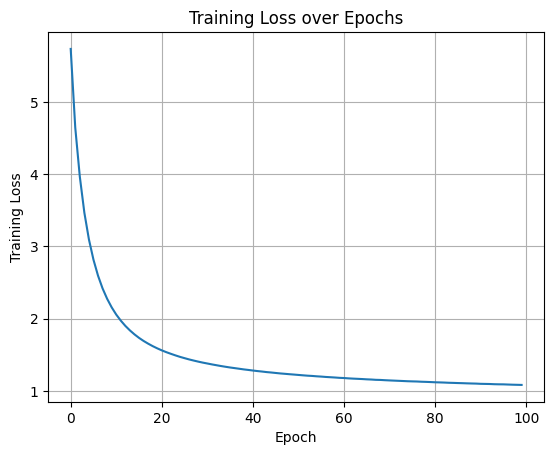


Training model with LSTM...


LSTM Training Epochs: 100%|██████████| 100/100 [03:24<00:00,  2.04s/it]


batch_loss,█▅▅▅▅▄▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇██
loss,█▇▇▅▄▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_loss,0.36919
epoch,100
loss,0.34791


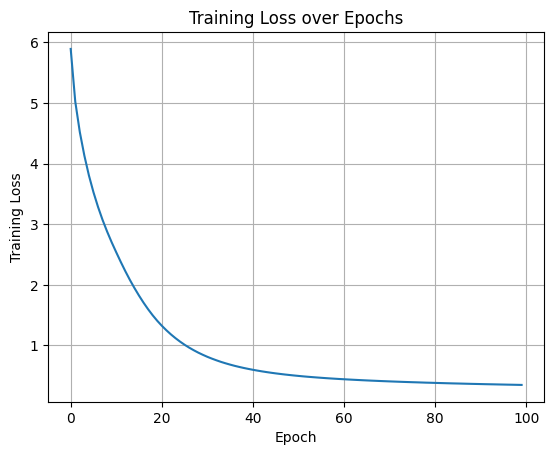


Training model with GRU...


GRU Training Epochs: 100%|██████████| 100/100 [03:09<00:00,  1.90s/it]


batch_loss,█▆▄▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
loss,█▆▅▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_loss,0.61162
epoch,100
loss,0.60924


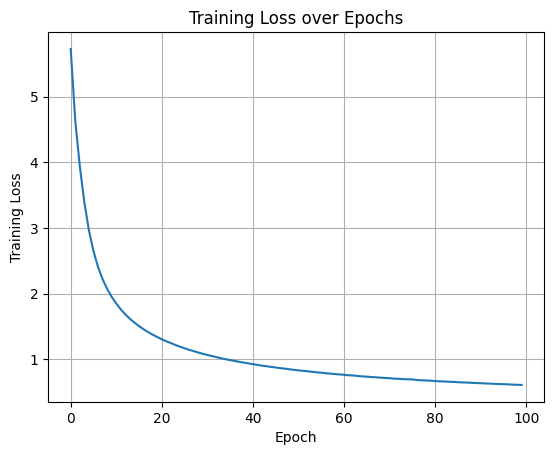

In [86]:
models = {}
histories = {}

for model_type in ["RNN", "LSTM", "GRU"]:
    model, history = train_model(model_type)
    models[model_type] = model
    histories[model_type] = history

    plt.plot(history, label=model_type)
    plt.xlabel("Epoch")
    plt.ylabel("Training Loss")
    plt.title("Training Loss over Epochs")
    plt.grid(True)
    plt.show()


In [ ]:
# save the model
# torch.save(model.state_dict(), MODEL_PATH)

In [ ]:
# load the model
# model = RNNLanguageModel(embedding_matrix, HIDDEN_SIZE, vocab_size)
# model.load_state_dict(torch.load(MODEL_PATH))

### Generate Text

In [87]:
def generate_text(model, seed_text, vocab, inv_vocab, max_len=20, temperature=1.0):
    model = model.to(_device)
    model.eval()
    tokens = word_tokenize(seed_text.lower())
    tokens = [t for t in tokens if t in vocab]

    if len(tokens) == 0:
        raise ValueError("Seed text contains no known vocabulary words.")

    input_ids = torch.tensor([[vocab.get(t, vocab["<unk>"]) for t in tokens]], dtype=torch.long).to(_device)

    generated = tokens[:]
    hidden = None

    for _ in range(max_len):
        output, hidden = model(input_ids, hidden)  # output: [1, seq_len, vocab_size]
        last_logits = output[0, -1] / temperature
        probs = torch.nn.functional.softmax(last_logits, dim=0).detach().cpu().numpy()
        next_token_id = np.random.choice(len(probs), p=probs)
        next_token = inv_vocab.get(next_token_id, "<unk>")

        generated.append(next_token)
        input_ids = torch.tensor([[next_token_id]], dtype=torch.long).to(_device)

    return " ".join(generated)

In [88]:
seed = "alice was beginning"
for temp in [0.5, 1.0, 1.5]:
    print(f"\n--- Temperature = {temp} ---")
    for model_type, model in models.items():
        print(f"\n{model_type} Model:")
        print(generate_text(model, seed, vocab, inv_vocab, max_len=30, temperature=temp))


--- Temperature = 0.5 ---

RNN Model:
alice was beginning to grow larger again for really once a little said alice i must be shutting up and perhaps as i eat would be so easily offended youll get used talk

LSTM Model:
alice was beginning to grow larger again and she thought at first she would get up and leave the court but on second thoughts she decided to remain where she was as long

GRU Model:
alice was beginning to feel that this is may the rabbit say he went said the pigeon but i should get to get to say it and as you do ill manage her

--- Temperature = 1.0 ---

RNN Model:
alice was beginning that you dont like it yer honour the gryphon whispered in reply its disappeared for him ill get which it might be quite round it said alice why it does

LSTM Model:
alice was beginning to grow again as quickly and she hastily dried her hands and was surprised to see that she had the door and who it was no room as it left

GRU Model:
alice was beginning very angrily but the mouse heard of d